## Quantum Annealing for the Nuclear Hamiltonian

### Overview on the Quantum Annealing cki

#### Imports

In [295]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

[1.63, 2.27]


In [296]:
nparticles_a=4
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Define the initial Hamiltonian

In [12]:

t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0.
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print(egs)

[-36.]


#### Initial Hamiltonian with M conservation

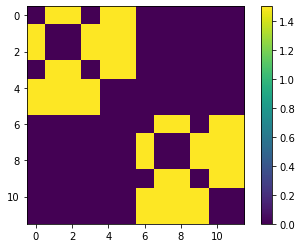

In [312]:

t=3.
h=4.
g=1.
r=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]




mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))


# for tzi in [-1/2,1/2]:
    
#     for tupi in mj_list:
#         for tupj in mj_list:
#             mi,ji=tupi
#             mj,jj=tupj
            
#             i=SPS.get_index((1,0,ji,mi,1/2,tzi))
#             k=SPS.get_index((1,0,ji,-1*mi,1/2,tzi))
#             j=SPS.get_index((1,0,jj,mj,1/2,tzi))
#             l=SPS.get_index((1,0,jj,-1*mj,1/2,tzi))
#             kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
#             kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#             adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        
        #if ni==nj:
        i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
        j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
        l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
        kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        mj,jj,nj=mj_list[(f-1)% len(mj_list)]
        
        #if ni==nj:
        i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
        j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
        l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
        kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        
        kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        # for f,tupi in enumerate(mj_list):
        #     mi,ji,ni=tupi
        #     rand=np.random.uniform(0,0.3)
            
        #     #if ni==nj:
        #     i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        #     j=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            
        #     kinetic_term[(i,j)]=h*(ji+rand)/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #     adj_matrix[i,j]=h**(ji+rand)/2#np.abs(mi-mj)#+np.abs(ji-jj)
        #     kinetic_term[(j,i)]=h**(ji+rand)/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        #     adj_matrix[j,i]=h**(ji+rand)/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            
            
        
    # for f,tupi in enumerate(mj_list):
    #     mi,ji,ni=tupi
    #     mj,jj,nj=tupi
    #     #if ni==nj:
    #     i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
    #     k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
    #     j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
    #     l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
    #     kinetic_term[(i,j)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
    #     adj_matrix[i,j]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
    #     kinetic_term[(i,l)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
    #     adj_matrix[i,l]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
    #     kinetic_term[(k,j)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
    #     adj_matrix[k,j]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
    #     kinetic_term[(k,l)]=t_diag/2 #np.abs(mi-mj)#+np.abs(ji-jj)
    #     adj_matrix[k,l]=t_diag/2#np.abs(mi-mj)#+np.abs(ji-jj)


# # for i in range(size_a):
# #     for j in range(size_a):
# #         (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
# #         (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
# #         if np.isclose(mi,-mj) and np.isclose(ni,nj):
            
# #             if size_b==size_a:    
# #                 kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)+g*np.abs(mi)

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

einitial,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)

plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Intermediate Hamiltonian

In [13]:
t=-9

IntermediateHamiltonian = FermiHubbardHamiltonian(
    size_a=size_a, size_b=size_b, nparticles_a=nparticles_a, nparticles_b=nparticles_b
)

kinetic_term: Dict = {}
adj_matrix = np.zeros((size_a, size_a))
for i in range(size_a):
    # kinetic_term[(i, (i+1)%size_a)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    # adj_matrix[i, (i+1)%size_a] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    
    for j in range(size_a):
        (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
        (nj, lj, jj, mj, tj, tzj) = SPS.state_encoding[j]
        if np.isclose(mi, 1-mj):  # and np.isclose(ji,jj):
            kinetic_term[(i, j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            if size_a==size_b:
                kinetic_term[(size_a + i, size_a + j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)


external_field = np.zeros(size_a +size_b)
for i in range(size_a +size_b):
    (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
    external_field[i] = ji

    # external_field[i] = SPS.energies[i]

IntermediateHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#IntermediateHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix_intermediate)
IntermediateHamiltonian.get_hamiltonian()

print(IntermediateHamiltonian.hamiltonian-IntermediateHamiltonian.hamiltonian.conjugate().transpose())
eng, _ = IntermediateHamiltonian.get_spectrum(n_states=1)
print(eng)
print(IntermediateHamiltonian.hamiltonian)


[-122.91168825]
  (0, 2)	-18.0
  (0, 30)	-18.0
  (1, 1)	-18.0
  (1, 4)	-18.0
  (1, 31)	-18.0
  (2, 0)	-18.0
  (2, 3)	-18.0
  (2, 32)	-18.0
  (3, 2)	-18.0
  (3, 33)	-18.0
  (4, 1)	-18.0
  (4, 4)	-18.0
  (4, 34)	-18.0
  (5, 5)	-18.0
  (5, 8)	-18.0
  (5, 9)	18.0
  (5, 35)	-18.0
  (6, 7)	-18.0
  (6, 36)	-18.0
  (7, 6)	-18.0
  (7, 12)	-18.0
  (7, 37)	-18.0
  (8, 5)	-18.0
  (8, 8)	-18.0
  (8, 13)	-18.0
  :	:
  (219, 220)	-18.0
  (219, 223)	18.0
  (220, 160)	18.0
  (220, 205)	-18.0
  (220, 219)	-18.0
  (220, 220)	-36.0
  (220, 224)	18.0
  (221, 161)	18.0
  (221, 206)	-18.0
  (221, 221)	-54.0
  (222, 162)	18.0
  (222, 207)	-18.0
  (222, 217)	-18.0
  (222, 222)	-18.0
  (223, 163)	18.0
  (223, 208)	-18.0
  (223, 218)	-18.0
  (223, 219)	18.0
  (223, 223)	-36.0
  (223, 224)	-18.0
  (224, 164)	18.0
  (224, 209)	-18.0
  (224, 220)	18.0
  (224, 223)	-18.0
  (224, 224)	-36.0


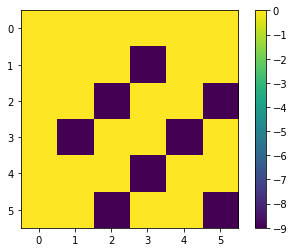

In [14]:
plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Define the target Hamiltonian

In [300]:
twobody_matrix,matrix_j,matrix_m,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]

{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 1, 5): -1.102

In [313]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_twobody_interaction(twobody_dict=matrix_m)
Moperator.get_hamiltonian()

size= 12 6
[-39.4534158]
  (0, 0)	-37.70165
  (0, 3)	2.2055000000000002
  (0, 17)	1.900998549179548
  (0, 20)	-1.900998549179548
  (0, 23)	-2.3986297010721485
  (0, 31)	0.17580399459981932
  (0, 34)	0.5966341818903775
  (0, 37)	1.3652289845057242
  (0, 46)	-0.1015004836068174
  (0, 49)	2.054162795550007
  (0, 52)	0.5966341818903771
  (0, 60)	-0.20300096721363547
  (0, 63)	-1.7096958900278656
  (0, 90)	0.20300096721363525
  (0, 93)	-0.6889338110442829
  (0, 135)	3.763858685577873
  (0, 180)	-3.763858685577873
  (1, 1)	-37.70165
  (1, 4)	1.1027500000000012
  (1, 7)	1.9100190280465794
  (1, 26)	-2.3986297010721485
  (1, 32)	1.1027499999999997
  (1, 35)	-0.7982485491795481
  (1, 40)	1.3652289845057242
  (1, 47)	1.5584110388469403
  :	:
  (222, 208)	0.07702499999999957
  (222, 216)	1.305750967213634
  (222, 221)	-0.8676708520516285
  (222, 222)	-29.10035000000001
  (223, 174)	-1.7096958900278656
  (223, 178)	-1.8993977705262892
  (223, 219)	2.4085009672136337
  (223, 223)	-30.44915000000000

#### Create the interpolate Hamiltonian and Perform the spectrum

100%|██████████| 100/100 [00:00<00:00, 138.08it/s]


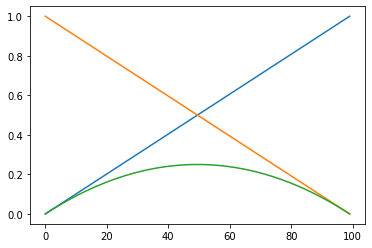

In [314]:
ngrid=100
nlevels=8
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)

plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=8,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = psis[:, a].conjugate() @ Moperator.hamiltonian @ psis[:, a]

    spectrum[:,i]=values
    psi_spectrum=psis

Spectrum

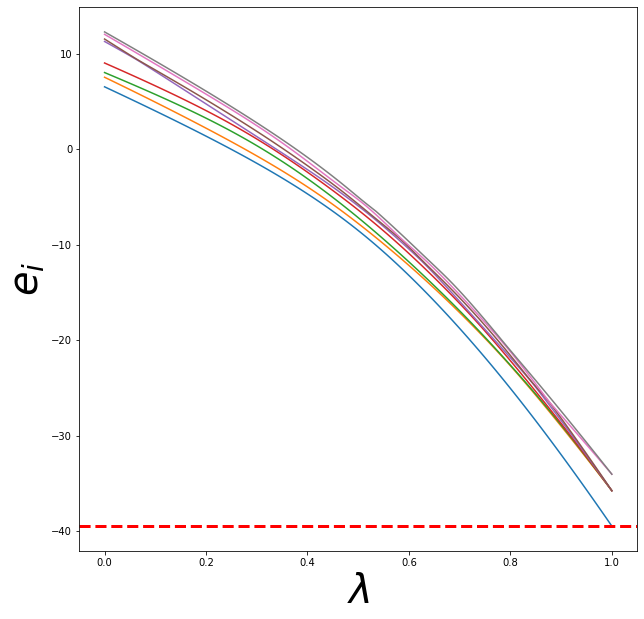

0.5117810212109909
-39.453415798057065


In [315]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)
plt.savefig('images/be10_spectrum_M_conservation')
plt.show()


t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

#### Expectation values

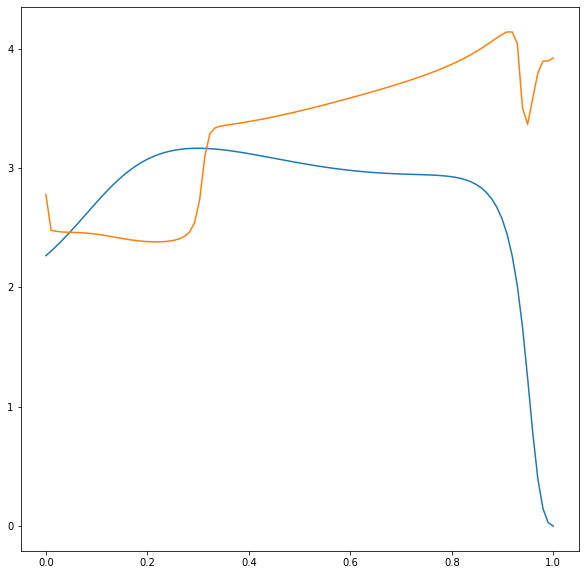

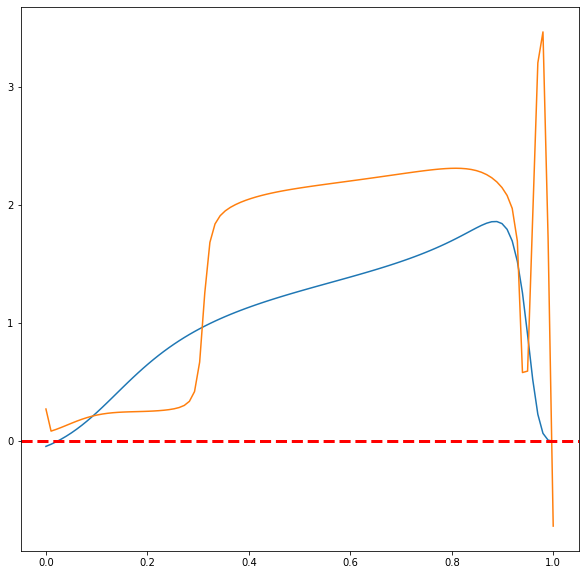

In [179]:
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, j_values[i])
# plt.xlim([0.9,1])
plt.show()


plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, m_values[i])
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### Simulation of the Quantum Annealing

In [253]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

100%|██████████| 1000/1000 [00:06<00:00, 149.08it/s]

[[0.00236235]]
(0.9697574453327871+0j)


(1000, 1, 1)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


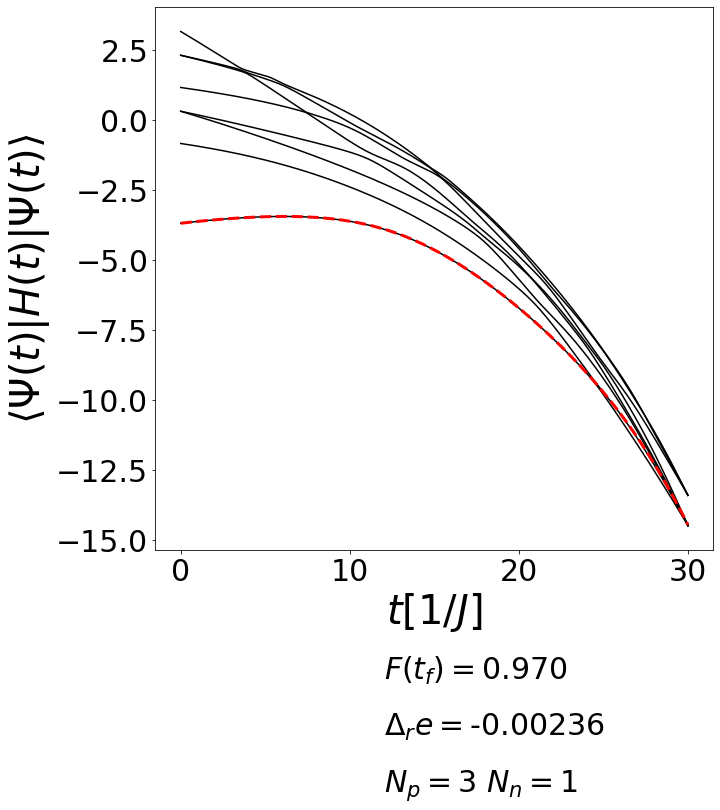

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


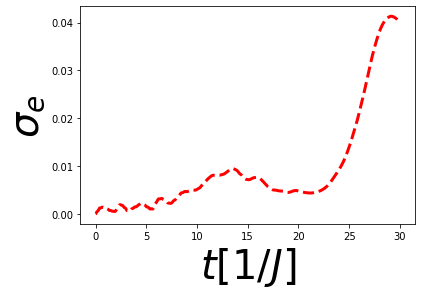

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


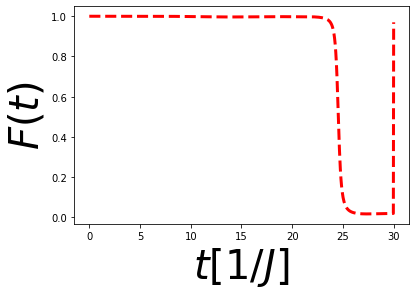

In [254]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be10_qa_m_conservation')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be10_fidelity_m_conservation')
plt.show()

### Overview on the Quantum Annealing usdb

#### Imports

In [316]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/usdb.nat'
SPS=SingleParticleState(file_name=file_name)

[-3.9257, -3.2079, 2.1117]


In [317]:
nparticles_a=2
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=0

#### Define the initial Hamiltonian

In [ ]:

t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=0.
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
print(egs)

[-36.]


#### Initial Hamiltonian with M conservation

[(2, 0, 2.5, -2.5, 0.5, 0.5), (2, 0, 2.5, -1.5, 0.5, 0.5), (2, 0, 2.5, -0.5, 0.5, 0.5), (2, 0, 2.5, 0.5, 0.5, 0.5), (2, 0, 2.5, 1.5, 0.5, 0.5), (2, 0, 2.5, 2.5, 0.5, 0.5), (1, 0, 0.5, -0.5, 0.5, 0.5), (1, 0, 0.5, 0.5, 0.5, 0.5), (2, 0, 1.5, -1.5, 0.5, 0.5), (2, 0, 1.5, -0.5, 0.5, 0.5), (2, 0, 1.5, 0.5, 0.5, 0.5), (2, 0, 1.5, 1.5, 0.5, 0.5), (2, 0, 2.5, -2.5, 0.5, -0.5), (2, 0, 2.5, -1.5, 0.5, -0.5), (2, 0, 2.5, -0.5, 0.5, -0.5), (2, 0, 2.5, 0.5, 0.5, -0.5), (2, 0, 2.5, 1.5, 0.5, -0.5), (2, 0, 2.5, 2.5, 0.5, -0.5), (1, 0, 0.5, -0.5, 0.5, -0.5), (1, 0, 0.5, 0.5, 0.5, -0.5), (2, 0, 1.5, -1.5, 0.5, -0.5), (2, 0, 1.5, -0.5, 0.5, -0.5), (2, 0, 1.5, 0.5, 0.5, -0.5), (2, 0, 1.5, 1.5, 0.5, -0.5)]


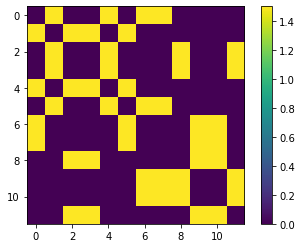

In [318]:

t=3.
h=4.
g=1.
r=5.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print(SPS.state_encoding)
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))


#usdb
j_values=[1/2,3/2,5/2]
n_values=[1,2,2]

mj_list=[]
for q,j in enumerate(j_values):
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,n_values[q]))


# for tzi in [1/2]:
    
#     for tupi in mj_list:
#         for tupj in mj_list:
#             mi,ji,ni=tupi
#             mj,jj,nj=tupj
            
#             if ni==nj:
#                 i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
#                 k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
#                 j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
#                 l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
#                 kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
#                 kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
#                 adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
                
for tzi in [1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        
        #if ni==nj:
        i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
        j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
        l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
        kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        mj,jj,nj=mj_list[(f-1)% len(mj_list)]
        
        #if ni==nj:
        i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
        k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
        j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
        l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
        kinetic_term[(i,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(i,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[i,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,j)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,j]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)
        
        kinetic_term[(k,l)]=t/2 #np.abs(mi-mj)#+np.abs(ji-jj)
        adj_matrix[k,l]=t/2#np.abs(mi-mj)#+np.abs(ji-jj)



# # for i in range(size_a):
# #     for j in range(size_a):
# #         (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
# #         (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
# #         if np.isclose(mi,-mj) and np.isclose(ni,nj):
            
# #             if size_b==size_a:    
# #                 kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
external_field=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=h*(ji)+g*np.abs(mi)+r*ni
    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

einitial,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)

plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Intermediate Hamiltonian

In [ ]:
t=-9

IntermediateHamiltonian = FermiHubbardHamiltonian(
    size_a=size_a, size_b=size_b, nparticles_a=nparticles_a, nparticles_b=nparticles_b
)

kinetic_term: Dict = {}
adj_matrix = np.zeros((size_a, size_a))
for i in range(size_a):
    # kinetic_term[(i, (i+1)%size_a)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    # adj_matrix[i, (i+1)%size_a] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
    
    for j in range(size_a):
        (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
        (nj, lj, jj, mj, tj, tzj) = SPS.state_encoding[j]
        if np.isclose(mi, 1-mj):  # and np.isclose(ji,jj):
            kinetic_term[(i, j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
            if size_a==size_b:
                kinetic_term[(size_a + i, size_a + j)] = t  # np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i, j] = t  # np.abs(mi-mj)#+np.abs(ji-jj)


external_field = np.zeros(size_a +size_b)
for i in range(size_a +size_b):
    (ni, li, ji, mi, ti, tzi) = SPS.state_encoding[i]
    external_field[i] = ji

    # external_field[i] = SPS.energies[i]

IntermediateHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#IntermediateHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix_intermediate)
IntermediateHamiltonian.get_hamiltonian()

print(IntermediateHamiltonian.hamiltonian-IntermediateHamiltonian.hamiltonian.conjugate().transpose())
eng, _ = IntermediateHamiltonian.get_spectrum(n_states=1)
print(eng)
print(IntermediateHamiltonian.hamiltonian)


[-122.91168825]
  (0, 2)	-18.0
  (0, 30)	-18.0
  (1, 1)	-18.0
  (1, 4)	-18.0
  (1, 31)	-18.0
  (2, 0)	-18.0
  (2, 3)	-18.0
  (2, 32)	-18.0
  (3, 2)	-18.0
  (3, 33)	-18.0
  (4, 1)	-18.0
  (4, 4)	-18.0
  (4, 34)	-18.0
  (5, 5)	-18.0
  (5, 8)	-18.0
  (5, 9)	18.0
  (5, 35)	-18.0
  (6, 7)	-18.0
  (6, 36)	-18.0
  (7, 6)	-18.0
  (7, 12)	-18.0
  (7, 37)	-18.0
  (8, 5)	-18.0
  (8, 8)	-18.0
  (8, 13)	-18.0
  :	:
  (219, 220)	-18.0
  (219, 223)	18.0
  (220, 160)	18.0
  (220, 205)	-18.0
  (220, 219)	-18.0
  (220, 220)	-36.0
  (220, 224)	18.0
  (221, 161)	18.0
  (221, 206)	-18.0
  (221, 221)	-54.0
  (222, 162)	18.0
  (222, 207)	-18.0
  (222, 217)	-18.0
  (222, 222)	-18.0
  (223, 163)	18.0
  (223, 208)	-18.0
  (223, 218)	-18.0
  (223, 219)	18.0
  (223, 223)	-36.0
  (223, 224)	-18.0
  (224, 164)	18.0
  (224, 209)	-18.0
  (224, 220)	18.0
  (224, 223)	-18.0
  (224, 224)	-36.0


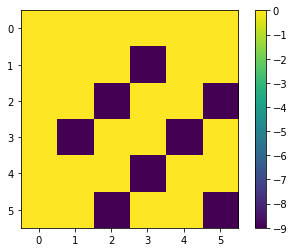

In [ ]:
plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Define the target Hamiltonian

In [319]:
twobody_matrix,matrix_j,matrix_m,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



 0 1 205 205 205 205 0 5

   0.0      -1.3796    0.0      -1.6651    0.0      -4.3205

  -2.5598    0.0      -1.0007    0.0      -0.2069    0.0

 0 1 205 205 205 203 1 4

   3.4987    0.0       2.3102    0.0

   0.0      -0.2137    0.0      -1.3349

 0 1 205 205 203 203 0 3

   0.0       1.6647    0.0       1.1792

  -3.1025    0.0      -1.2187    0.0

 0 1 205 205 203 1001 1 2

   0.0272    0.0

   0.0       0.8866

 0 1 205 205 205 1001 2 3

   0.00000  -1.2167

  -0.93170   0.00000

 0 1 205 205 1001 1001 0 1

   0.00000  -0.5344

  -1.5602    0.00000

 0 1 205 203 205 203 1 4

  -6.0099   -4.2117   -1.2124   -4.6189

   0.6556   -0.1545    0.7673   -1.4447

 0 1 205 203 203 203 1 3

   0.1922    0.0       1.4300

   0.0      -0.5032    0.0

 0 1 205 203 203 1001 1 2

   1.6231   -0.4429

  -0.0736    0.3713

 0 1 205 203 1001 1001 1 1

   2.0226

   0.00000

 0 1 205 203 205 1001 2 3

  -0.6464    1.2526

  -0.3147   -0.5525

 0 1 205 1001 203 203 2 3

   0.00000   0.0968

  -0.317

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [01:33<00:00,  3.90s/it]

{(0, 1, 0, 1): -0.20690000000000003, (0, 1, 1, 0): 0.20690000000000003, (1, 0, 0, 1): 0.20690000000000003, (1, 0, 1, 0): -0.20690000000000003, (0, 1, 0, 8): 1.3349000000000004, (0, 1, 8, 0): -1.3349000000000004, (1, 0, 0, 8): -1.3349000000000004, (1, 0, 8, 0): 1.3349000000000004, (0, 2, 0, 2): -0.20690000000000003, (0, 2, 2, 0): 0.20690000000000003, (2, 0, 0, 2): 0.20690000000000003, (2, 0, 2, 0): -0.20690000000000003, (0, 2, 0, 9): 0.8174559644103165, (0, 2, 9, 0): -0.8174559644103165, (2, 0, 0, 9): -0.8174559644103165, (2, 0, 9, 0): 0.8174559644103165, (0, 2, 1, 8): 1.0553311121396927, (0, 2, 8, 1): -1.0553311121396927, (2, 0, 1, 8): -1.0553311121396927, (2, 0, 8, 1): 1.0553311121396927, (0, 3, 0, 3): -0.49040000000000067, (0, 3, 3, 0): 0.49040000000000067, (3, 0, 0, 3): 0.49040000000000067, (3, 0, 3, 0): -0.49040000000000067, (0, 3, 0, 7): -0.5082840208321859, (0, 3, 7, 0): 0.5082840208321859, (3, 0, 0, 7): 0.5082840208321859, (3, 0, 7, 0): -0.5082840208321859, (0, 3, 0, 10): 0.4384

In [320]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_twobody_interaction(twobody_dict=matrix_m)
Moperator.get_hamiltonian()

size= 12 0
[-11.93178825]
  (0, 0)	-0.20690000000000003
  (0, 7)	1.3349000000000004
  (1, 1)	-0.20690000000000003
  (1, 8)	0.8174559644103165
  (1, 17)	1.0553311121396927
  (2, 2)	-0.49040000000000067
  (2, 6)	-0.5082840208321859
  (2, 9)	0.43846666512286636
  (2, 11)	0.38035516297271443
  (2, 15)	0.22731152449153724
  (2, 18)	0.7045557553875234
  (2, 26)	0.6878971546765281
  (2, 52)	0.5298448425179374
  (2, 60)	-0.7283125530979135
  (3, 3)	-0.7739000000000005
  (3, 10)	0.20328479938540378
  (3, 12)	0.35860228666309424
  (3, 16)	-0.642934081639272
  (3, 19)	0.397157607427271
  (3, 24)	0.4546230489830745
  (3, 27)	0.4237229179758753
  (3, 34)	0.4039191163524205
  (3, 53)	0.6489247535071275
  (3, 56)	0.37465688112115164
  (3, 61)	-1.0299894902376436
  :	:
  (63, 51)	0.7177133829043456
  (63, 54)	0.17470000000000002
  (63, 57)	0.17470000000000002
  (63, 62)	0.9008999999999998
  (63, 63)	-0.9982999999999997
  (64, 14)	-1.029989490237643
  (64, 22)	0.651422551037343
  (64, 29)	0.28528758422

#### Create the interpolate Hamiltonian and Perform the spectrum

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 231.42it/s]


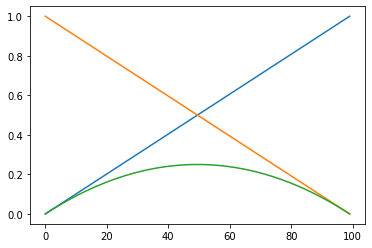

In [321]:
ngrid=100
nlevels=8
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)

plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=8,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = psis[:, a].conjugate() @ Moperator.hamiltonian @ psis[:, a]

    spectrum[:,i]=values
    psi_spectrum=psis

Spectrum

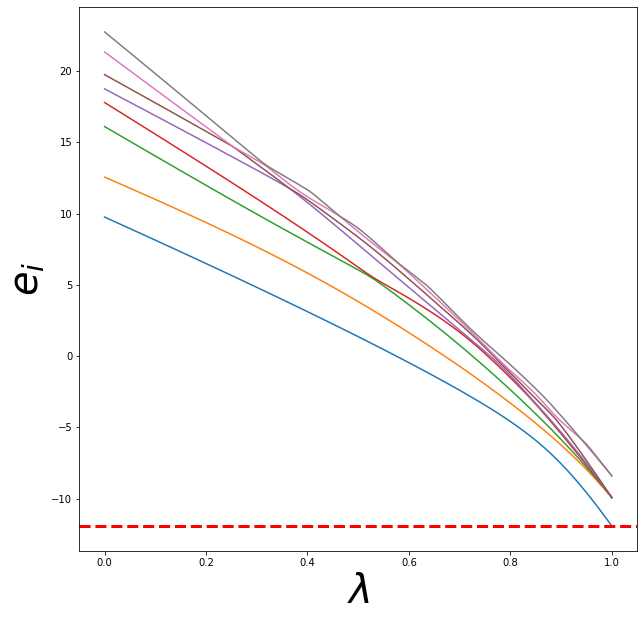

1.448867943787987
-11.931788251561521


In [322]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)
plt.savefig('images/o18_spectrum_M_conservation')
plt.show()


t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[0,-1])

#### Expectation values

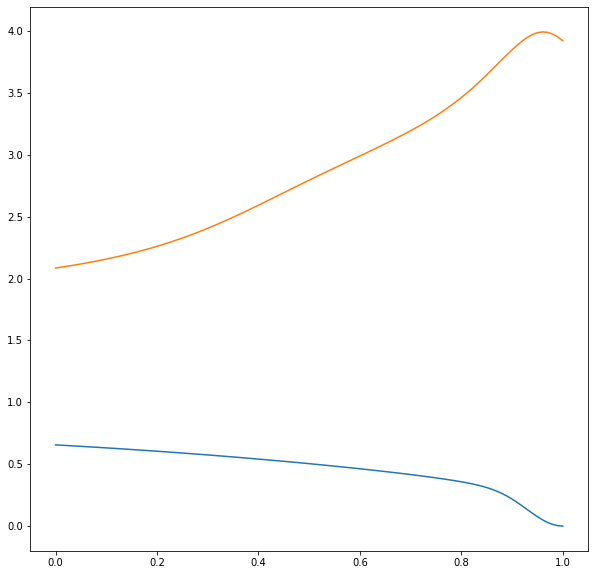

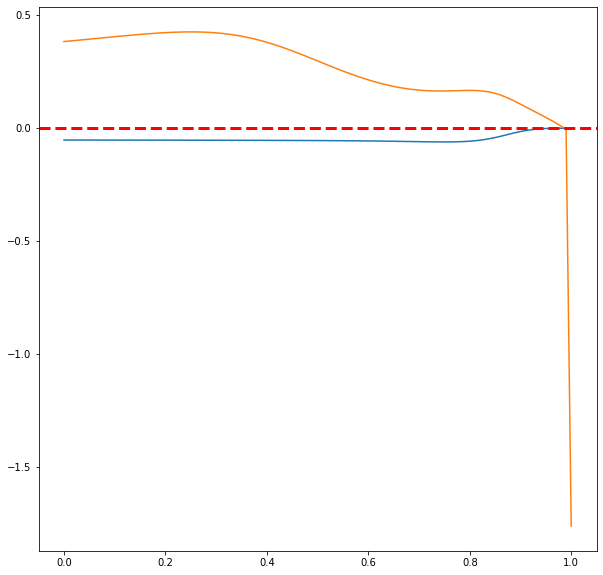

In [323]:
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, j_values[i])
# plt.xlim([0.9,1])
plt.show()


plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(lambd, m_values[i])
plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.show()

#### Simulation of the Quantum Annealing

In [324]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

100%|██████████| 1000/1000 [00:05<00:00, 198.71it/s]

[[0.00050422]]
(0.9974983430767972+0j)


(1000, 1, 1)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


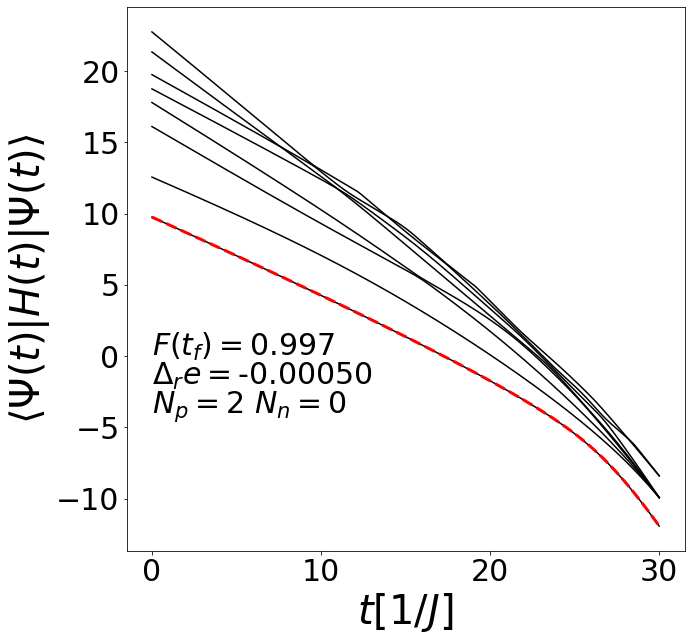

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


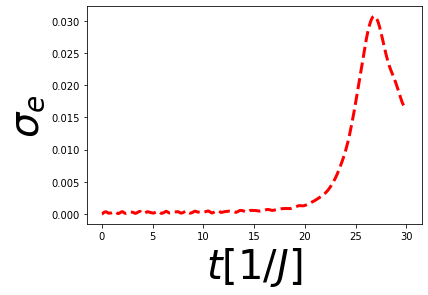

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


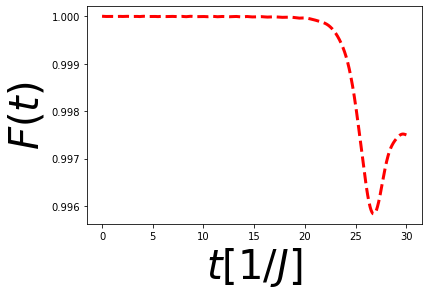

In [325]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=0,y=0,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=0, y=-2, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=0,
    y=-4,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/o18_qa_m_conservation')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/o18_fidelity_m_conservation')
plt.show()

### Gap VS hopping term

#### Imports

In [2]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

[1.63, 2.27]


In [5]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Define the target Hamiltonian

In [3]:
twobody_matrix,matrix_j,matrix_m,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 1, 5): -1.102

In [6]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_twobody_interaction(twobody_dict=matrix_m)
Moperator.get_hamiltonian()

size= 12 6
[-30.29539461]
  (0, 0)	-20.565460000000012
  (0, 3)	2.4085009672136346
  (0, 45)	2.4085009672136355
  (0, 48)	-0.6889338110442829
  (1, 1)	-18.249465000000004
  (1, 4)	1.3057509672136356
  (1, 7)	1.9100190280465794
  (1, 15)	-2.315995000000001
  (1, 18)	0.10150048360681718
  (1, 46)	2.307000483606819
  (1, 49)	1.7096958900278656
  (1, 60)	-0.10150048360681718
  (1, 63)	-2.054162795550007
  (1, 105)	0.17580399459982032
  (1, 108)	-0.5966341818903769
  (2, 2)	-17.877325000000003
  (2, 5)	1.043099999999999
  (2, 8)	1.1027499999999997
  (2, 10)	1.1027499999999997
  (2, 14)	-3.7638586855778717
  (2, 16)	-1.2256337924518892
  (2, 19)	0.17580399459981977
  (2, 30)	-1.9530200000000002
  (2, 33)	1.9009985491795476
  (2, 47)	4.106498549179548
  :	:
  (223, 219)	2.205499999999999
  (223, 223)	-12.497387499999997
  (224, 44)	-3.763858685577873
  (224, 58)	-2.3986297010721485
  (224, 71)	0.5966341818903769
  (224, 72)	1.3652289845057242
  (224, 89)	3.763858685577873
  (224, 116)	2.05416

#### Create the interpolate Hamiltonian and Perform the spectrum

In [ ]:
ts=np.linspace(-10,10,50)

gap=np.ones_like(ts)
min_lambd=np.ones_like(ts)

for r,t in enumerate(ts):

    InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

    kinetic_term:Dict={}
    adj_matrix=np.zeros((size_a,size_a))
    for i in range(size_a):
        for j in range(size_a):
            (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
            (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
            if np.isclose(mi,-mj) and np.isclose(ni,nj):
                kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
                adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                if size_b==size_a:    
                    kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                    
    external_field=np.zeros(size_a+size_b)
    for i in range(size_a+size_b):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        external_field[i]=0.
        
        #external_field[i] = SPS.energies[i]


    InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
    InitialHamiltonian.get_external_potential(external_field)
    InitialHamiltonian.get_hamiltonian()

    egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)
    print(egs)

    ngrid=100
    nlevels=8
    lambd=np.linspace(0,1.,ngrid)

    spectrum=np.zeros((nlevels,ngrid))
    psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
    j_values=np.zeros_like(spectrum)
    m_values = np.zeros_like(spectrum)

    plt.plot(lambd)
    plt.plot(1-lambd)
    plt.plot(lambd*(1-lambd))

    for i in trange(ngrid):

        ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

        values,psis=eigsh(ham,k=8,which='SA')
        for a in range(psis.shape[-1]):    
            j_values[a,i]=psis[:,a].conjugate() @ Joperator.hamiltonian @ psis[:,a]
            m_values[a, i] = psis[:, a].conjugate() @ Moperator.hamiltonian @ psis[:, a]

        spectrum[:,i]=values
        psi_spectrum=psis
        
    gap[r]=np.min(spectrum[1]-spectrum[0])
    min_lambd[r]=np.argmin(np.min(spectrum[1]-spectrum[0]))

#### GAP VS t

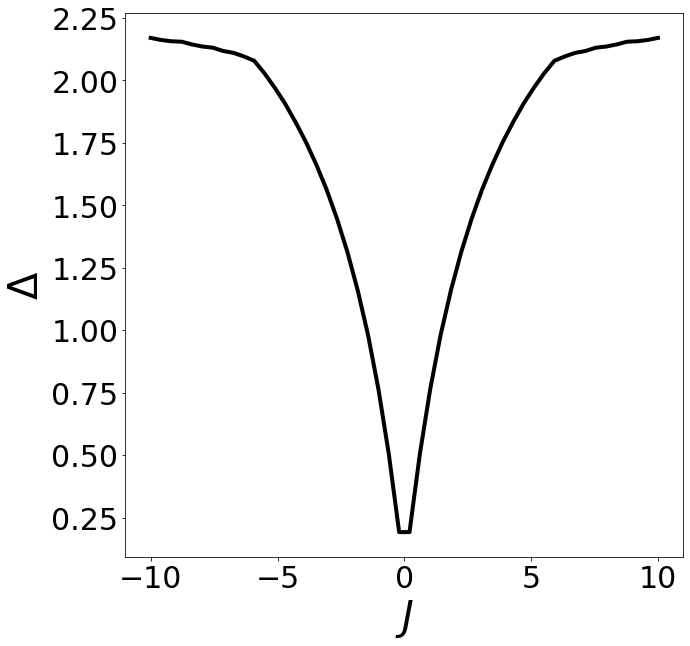

In [17]:
plt.figure(figsize=(10, 10))
plt.xlabel(r'$J$',fontsize=40)
plt.ylabel(r'$\Delta$',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.plot(ts,gap,color='black',linewidth=4)
plt.savefig('images/be8_gap_hopping_term_noconservation_of_m')
plt.show()



#### Simulation of the Quantum Annealing

In [ ]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

100%|██████████| 1000/1000 [00:08<00:00, 118.03it/s]

[[0.00083578]]
(0.9911743179449596+0j)


(1000, 1, 1)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


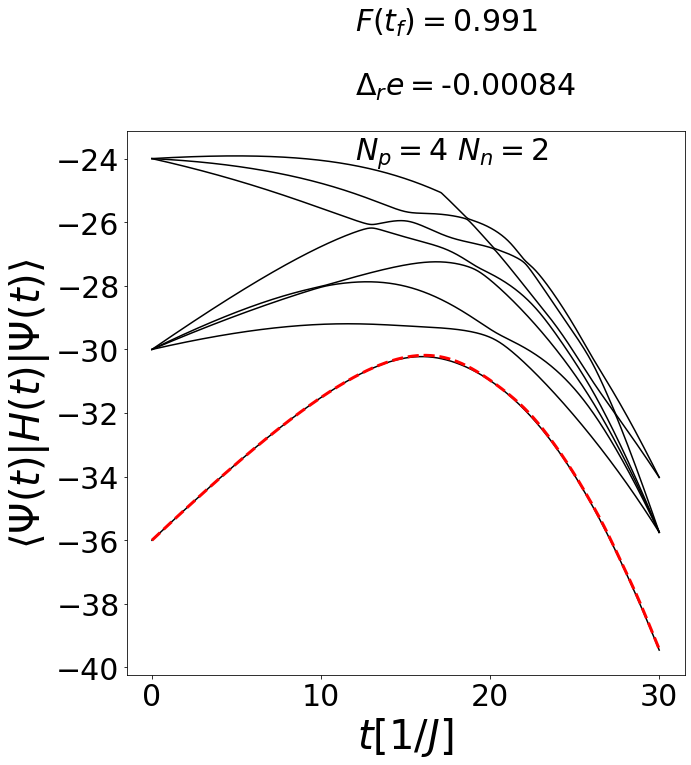

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


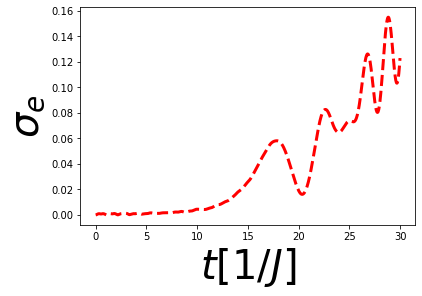

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


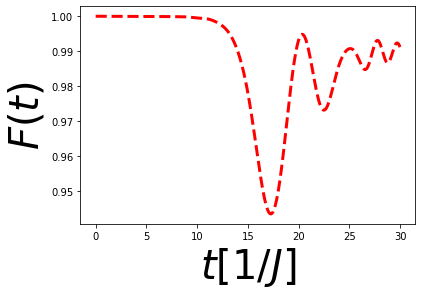

In [ ]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be10_qa')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be10_fidelity')
plt.show()

In [225]:
nstep =1000
tf = 30
time = np.linspace(0.0, tf, nstep)
psi = psi_initial
spectrum = np.zeros((nlevels, nstep))
dt=time[1]-time[0]
eng_t=[]
variance_t=[]
fidelity_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=8, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:, 0]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:, 0])
            count=count+1

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)

100%|██████████| 1000/1000 [00:08<00:00, 118.03it/s]

[[0.00083578]]
(0.9911743179449596+0j)


(1000, 1, 1)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


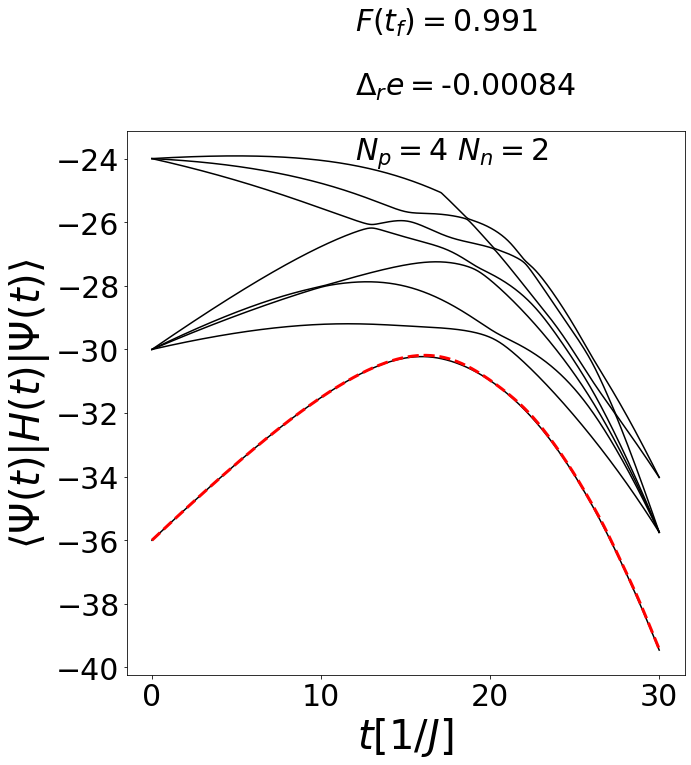

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


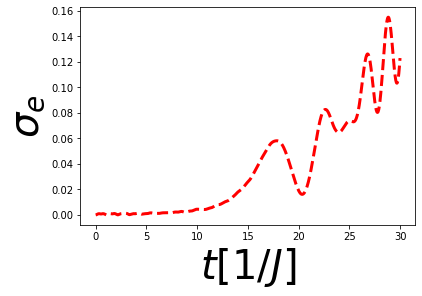

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


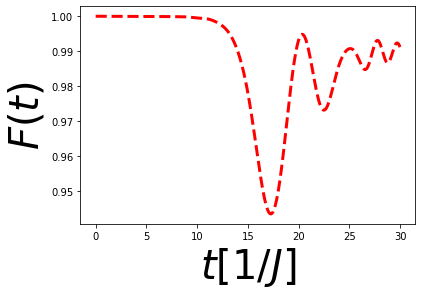

In [226]:
print(eng_t.shape)
plt.figure(figsize=(10, 10))
for i in range(nlevels):
    plt.plot(time, spectrum[i],color='black')


plt.plot(time,eng_t[:,0,0],color='red',linestyle='--',linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$\langle \Psi(t)| H(t)| \Psi(t) \rangle$',fontsize=40)
plt.text(x=tf*2/5,y=-20,s=r'$F(t_f)=$'+f'{fidelity.real:.3f}',fontsize=30)
# plt.text(x=tf * 2 / 5, y=-22, s=r"$T_f=$" + f"{tf:.1f} 1/J, h1 strategy", fontsize=30)
plt.text(x=tf * 2 / 5, y=-22, s=r"$\Delta_r e=$" + f"{(eng_t[-1,0,0].real-egs[0])/egs[0]:.5f}", fontsize=30)

plt.text(
    x=tf * 2 / 5,
    y=-24,
    s=r"$N_p=$" + f"{nparticles_a} " + r"$N_n=$" + f"{nparticles_b}",
    fontsize=30,
)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which="minor", labelsize=30)
plt.savefig('images/be10_qa')
plt.show()


plt.plot(time, variance_t[:, 0, 0], color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$\sigma_e$", fontsize=40)
plt.show()

plt.plot(time, fidelity_t, color="red", linestyle="--", linewidth=3)
# plt.xlim([0.9,1])
plt.xlabel(r"$t[1/J]$", fontsize=40)
plt.ylabel(r"$F(t)$", fontsize=40)
plt.savefig('images/be10_fidelity')
plt.show()